In [1]:
import h5py
import numpy as np
from numpy import array, exp
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.optimize import curve_fit
import scipy
from scipy import stats
import time
import glob
import tables as tb
from scipy.signal import find_peaks
import spectroscopy_update as spec
import math

In [2]:
# import the file. Just copy and paste the file path

f = h5py.File('D:/Documents/Berkeley Documents/Fall 2022/Detectors NE204/1027_cs137.h5', 'r')

In [3]:
# see array of raw data

rdata = np.array(f['raw_data'])
rdf = pd.DataFrame(rdata)
rdf

,0,1,2,3,4,5,6,7,8,9,...,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,7972,7969,7970,7974,7973,7969,7975,7970,7969,7971,...,8113,8108,8109,8111,8107,8110,8114,8109,8110,8112
1,7973,7974,7971,7974,7971,7974,7973,7968,7970,7973,...,7994,7998,8000,7996,8001,8000,8000,8000,7998,7995
2,7976,7967,7973,7969,7967,7973,7971,7969,7973,7973,...,8013,8008,8011,8012,8005,8013,8009,8013,8010,8013
3,7975,7970,7970,7968,7967,7971,7968,7972,7969,7975,...,8006,8004,8005,8001,8003,8006,8004,7999,7998,8006
4,7994,7995,7995,7995,7991,7995,7997,7994,7994,7996,...,8037,8031,8032,8027,8032,8029,8032,8033,8034,8033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89381,7968,7969,7971,7973,7972,7972,7976,7973,7969,7970,...,8015,8010,8011,8009,8008,8009,8015,8018,8011,8018
89382,7974,7976,7972,7972,7970,7972,7970,7970,7974,7974,...,8260,8257,8262,8262,8260,8257,8257,8256,8255,8256
89383,7967,7970,7972,7972,7976,7971,7974,7969,7968,7970,...,8057,8064,8057,8056,8058,8056,8056,8063,8060,8056
89384,8031,8030,8024,8030,8025,8025,8025,8029,8023,8029,...,8038,8042,8042,8037,8041,8042,8038,8038,8038,8039


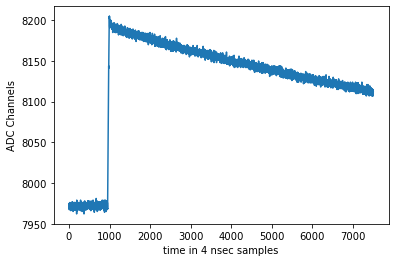

In [4]:
# plotting some of the adc curves

plt.plot(rdata[0,:])
plt.xlabel('time in 4 nsec samples')
plt.ylabel('ADC Channels')
plt.show()

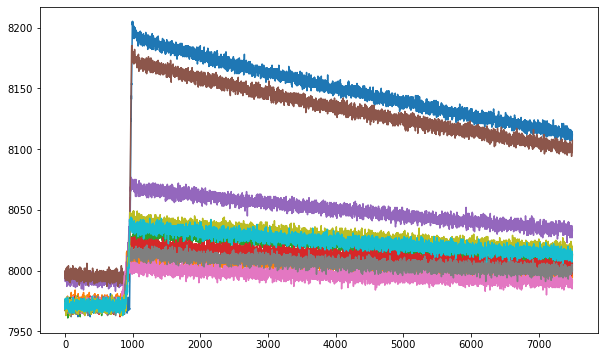

In [5]:
# Here are multiple pulses

plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(rdata[i])
    
plt.show()
plt.xlabel('time in 4 nsec samples')
plt.ylabel('ADC Channels')
plt.close()

[ 203.87184123   46.8662448  8005.28798548]


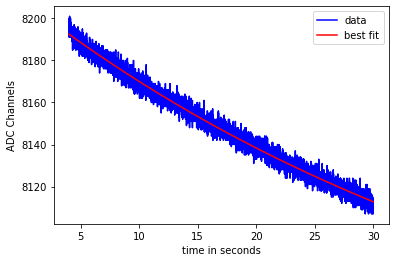

In [6]:
# Here is the curve fitting function to determine each pulse's decay constant

def func(x, a, b, c):
#     return a*np.exp(-b*x)+c
    return a*np.exp(-x/b)+c

xdata = np.arange(len(rdata[0,:]))*4e-9*1e6 # this changes from sample units to micro-seconds
xdata1 = xdata[1000:20000]
ydata = rdata[0,:]
ydata1 = ydata[1000:20000]
popt, pcov = curve_fit(func, xdata1, ydata1, p0=[150,8000,60], maxfev=10000) # p0 is starting point for a,b,c values
# maxfev is number of attempts python will make to zero in on the best fit
print(popt)

plt.plot(xdata1, ydata1, 'b-', label='data') # b- makes it a blue line and gives the line a name
plt.plot(xdata1, func(xdata1, *popt), 'r-', label='best fit') # r- makes it a red line
plt.xlabel('time in seconds')
plt.ylabel('ADC Channels')
plt.legend()

[46.866244804367355, -57283.67259454749, -37792.7338146703, 101.997603642209, 57.88495130878525, 46.596651313901745, 36960.90442805891, 33.31751449399016, 44.37100161172106, 52.223238437153185, 87.40966987928627, 45.29916293043256, 37.914945583380764, 35.32453117617674, 38.044547503100674, 21721.47209794827, 54.63110747174298, 37.403455014369705, -38.94213955194608, 45.72705854328655, 45.81668973492903, 40.288966349040884, 45.32615403665292, 64.38853607505412, 49.12080321913497, 47.70572777581402, 48.618518104517214, 36.65861544331538, 46237.50273099018, 51.96821976209145, 31.634121569220238, 30918.608355636763, 56.671384971343045, 48.75276694906605, 73.50101059080929, 44.82687043067838, -39.74859380051846, 171.75311086769167, 38.98656588746673, 42.12490419056691, 96801.37476789202, 55.578112200567375, 40224.203997975776, -124659.33352818184, 36273.97567277274, 62.247704576642654, 48549.15238250828, 53.423278260106265, 45.85907828354773, 57.63267228991309, 41.495244564342606, 43511.417

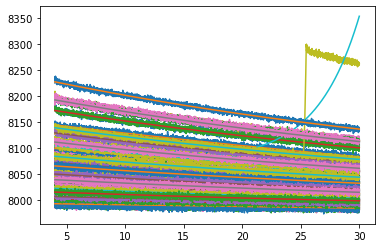

In [7]:
## This generates a decay constant for multiple pulses, but the output is not used in this code

tauarray=[]
for row in rdata[:100]:
    def func(x, a, b, c):
        return a*np.exp(-x/b)+c
    xdata = np.arange(len(row))*(4e-9)*(1e6)
    xdata1 = xdata[1000:10000]
    ydata = row[1000:10000]
    popt, pcov = curve_fit(func, xdata1, ydata, p0=[150,8000,60], maxfev=5000)
    tauarray.append(popt[1])
    plt.plot(xdata1, ydata)
    plt.plot(xdata1, func(xdata1, *popt))
print(tauarray)


In [8]:
# Remove the baseline, normalize to the highest pulse

def normalizer(v, baseline_idx = 200):
    #Normalize waveforms such that baseline before rising is on average 0, and the maximum height of the pulse is 1
    baseline_mean = v[:,baseline_idx].mean()
    return (v-baseline_mean) / (v.max()-baseline_mean) 

# Turn an exponential waveform into a step function

def exp_to_step(v, tau):
    #v is the exponential raw waveform
    f = np.zeros_like(v)
    # np.zeros_like(v) creates an array of zeros the size of v
    for n in range(v.shape[1]):
        if n==0:
            #Technically not correct, but should be fine I think
            f[:, n] = 0
        if n!=0:
            f[:, n] = f[:, n-1] + v[:, n] - v[:, n-1]*(1-1/tau)
    return f

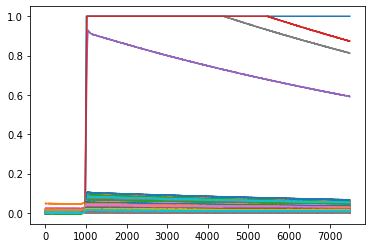

In [10]:
# Applying normalization to data file
# Visual proof of baseline correction and normalization

normalized_rdata = normalizer(rdata)
for i in range(5000):
    plt.plot(normalized_rdata[i, :])
plt.show()

In [12]:
# Pulling tau, the decay constant, from the curve fit, and converting from us back to samples

tau = popt[1]
time_conv = 1e-6 / (4e-9)
tau_idx = tau*time_conv
tau_idx

12930.53326486074

In [13]:
# Apply step function filter to the normalized pulses

test_step = exp_to_step(normalized_rdata[0:5000, :], tau_idx)

In [14]:
np.shape(test_step)

(5000, 7500)

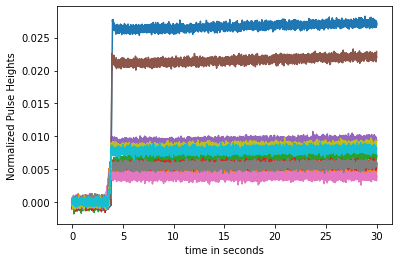

In [15]:
# Visualize the normalized step functions

for i in range(10):
    plt.plot(xdata, test_step[i,:])
plt.xlabel('time in seconds')
plt.ylabel('Normalized Pulse Heights')
plt.show()

In [16]:
# Here we define the trapezoid filter

def trap_filter(f, l, m):
    s = np.zeros_like(f)
    for n in range((2*l+m), f.shape[1]):
        if n==(2*l+m):
            s[:, n] = 0
        if n!=(2*l+m):
            s[:, n] = s[:, n-1] + f[:, n]-f[:, n-l-1]-f[:, n-l-m] + f[:, n-2*l-m-1]
    return s

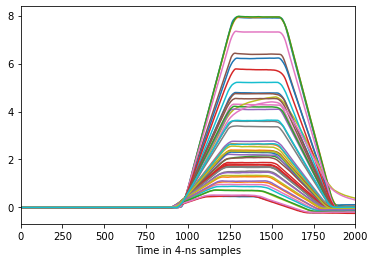

In [21]:
## Here we apply the trapezoid filter. Choose values for (l, m) to play with trapezoid gap/rise time.

test_trap = trap_filter(test_step[0:5000, :], 300, 300)
for i in range(50):
    plt.plot(test_trap[i,:])
plt.xlim(0, 2000)
plt.xlabel('Time in 4-ns samples')
plt.show()

In [22]:
test_trap[0]

array([0.        , 0.        , 0.        , ..., 0.00899269, 0.00861929,
       0.00836478])

In [24]:
## Here we pull all the maximum values of each trapezoid

trap_peaks = []
for i in range(0, 5000):
    trap_peaks.append(np.max(test_trap[i]))

Text(0.5, 0, 'normalized trap heights')

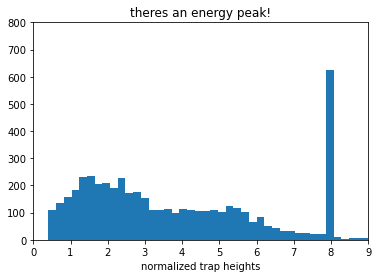

In [27]:
## here's a histogram of trap peaks that should produce a spike corresponding to Cs-137 decay

plt.hist(trap_peaks, bins=1500)
plt.ylim(0,800)
plt.title('theres an energy peak!')
plt.xlim(0, 9)
plt.xlabel('normalized trap heights')

[  1   0   1   2   4   1   1   0  12  26  87 147 149 113  62  21   5   0
   1   0   0   1   0   0]
[7.8    7.8125 7.825  7.8375 7.85   7.8625 7.875  7.8875 7.9    7.9125
 7.925  7.9375 7.95   7.9625 7.975  7.9875 8.     8.0125 8.025  8.0375
 8.05   8.0625 8.075  8.0875]


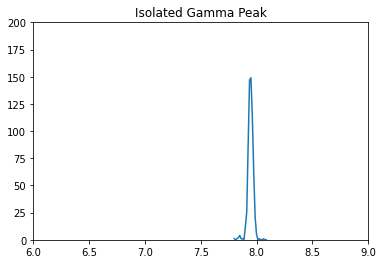

In [33]:
## Here we recreate the histogram
## Manually pare down "bins" and "n" to isolate the desired energy peak.

xmin = 0
xmax = 250
def gen_histogram(self, data, binsize=0.1):
        n, bins = np.histogram(trap_peaks, range=(0, 10), bins=(800))
        return(n, bins[:])
n, bins = gen_histogram(trap_peaks, 100)
n = np.array(n)
bins = np.array(bins[:-1])
bins2 = bins[bins>7.8]
n2=n[bins>7.8]
bins3 = bins2[bins2<8.1]
n3=n2[bins2<8.1]
print(n3)
print(bins3)


plt.plot(bins3,n3)
plt.title('Isolated Gamma Peak')
plt.ylim(0,200)
plt.xlim(6,9)
plt.show()

0.01988945872809726


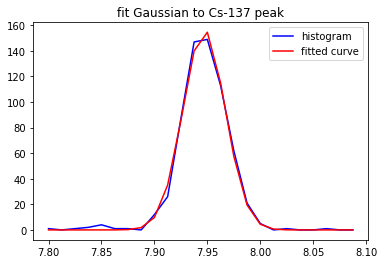

In [34]:
## try to implement Gaussian from stack overflow

def gaus(x,a,x0,sigma):
     return a*np.exp(-(x-x0)**2/(2*sigma**2))
    # a is amplitude, x0 is mean, sigma is std_dev
# times = bins3, amplitude = n3

mean = sum(np.array(bins3)*np.array(n3))/sum(n3)            
sigma = np.sqrt(sum(np.array(n3)*(np.array(bins3)-mean)**2)/sum(n3))        

params,pcov = curve_fit(gaus, bins3, n3, p0=[max(n3),mean,sigma], maxfev=10000)
print(params[2])

plt.plot(bins3, n3, 'b', label='histogram')
plt.plot(bins3, gaus(np.array(bins3),*params),'r',  label="fitted curve")

plt.title("fit Gaussian to Cs-137 peak")
plt.legend()
plt.show()

In [35]:
FWHM = 2*np.sqrt(2*np.log(2))*params[2]
print("FWHM is", FWHM)
print("mean value is", params[1])
print("therefore resolution is", 100*FWHM/params[1],"%")

FWHM is 0.04683609609773919
mean value is 7.946890176009059
therefore resolution is 0.589363827363981 %


In [36]:
print("FWHM in ADC channel for 662 keV:")
with np.printoptions(precision=3):
    print(FWHM)

FWHM in ADC channel for 662 keV:
0.04683609609773919


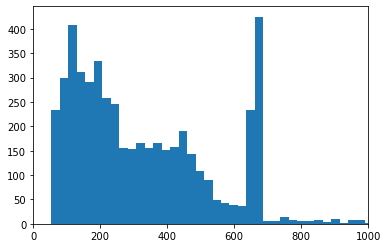

In [26]:
## Take the values for (m, b) from the calibration Notebook and plug them in here.

m = 247.13355243027533
b = -1.0798524991243563

def linearcal(data):
    return np.multiply(data,m) + b
    
plt.hist(linearcal(trap_peaks), bins=1000)
plt.xlim(0,1000)
plt.show()